# VARIABLE PRESELECTION

## IMPORT PACKAGES


In [1]:
import sys
import os
sys.path.append(os.path.abspath('..')) 

from paths import (
    TRANSFORMED_DATA_DIR,
    VALIDATION_DIR
)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

%config IPCompleter.greedy=True

## IMPORT DATA

In [4]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR / 'df_transformed.parquet')
df

,date,store_id,item_id,year_2013,year_2014,year_2015,month_1,month_2,month_3,month_4,...,sales_maxm_6,sales_maxm_7,sales_maxm_8,sales_maxm_9,sales_maxm_10,sales_maxm_11,sales_maxm_12,sales_maxm_13,sales_maxm_14,sales_maxm_15
0,2013-01-16,CA_3,FOODS_3_090,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
1,2013-01-17,CA_3,FOODS_3_090,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
2,2013-01-18,CA_3,FOODS_3_090,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
3,2013-01-19,CA_3,FOODS_3_090,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,281.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
4,2013-01-20,CA_3,FOODS_3_090,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20975,2015-11-26,CA_4,FOODS_3_714,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,15.0,15.0,15.0,15.0,15.0,17.0,17.0,17.0,17.0,17.0
20976,2015-11-27,CA_4,FOODS_3_714,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0
20977,2015-11-28,CA_4,FOODS_3_714,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0
20978,2015-11-29,CA_4,FOODS_3_714,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0


## SUPERVISED METHODS

### Split the data into x and y

In [5]:
target = 'sales'
x = df.drop(columns = ['date','store_id','item_id','sales']).copy()
y =  df[target].copy()

### Mutual Information

#### Create a function to show the result

In [6]:
def ranking_mi(mutual_selector, mode = 'table'):
    #Make the ranking
    ranking_mi = pd.DataFrame(mutual_selector, index = x.columns).reset_index()
    ranking_mi.columns = ['variable','importance_mi']
    ranking_mi = ranking_mi.sort_values(by = 'importance_mi', ascending = False)
    ranking_mi['ranking_mi'] = np.arange(0,ranking_mi.shape[0])
    #Show the output
    if mode == 'table':
        return(ranking_mi)
    else:
        g = ranking_mi.importance_mi.sort_values().plot.barh(figsize = (12,20))
        g.set_yticklabels(ranking_mi.sort_values(by = 'importance_mi').variable)
        return(g)

#### Calculate and review

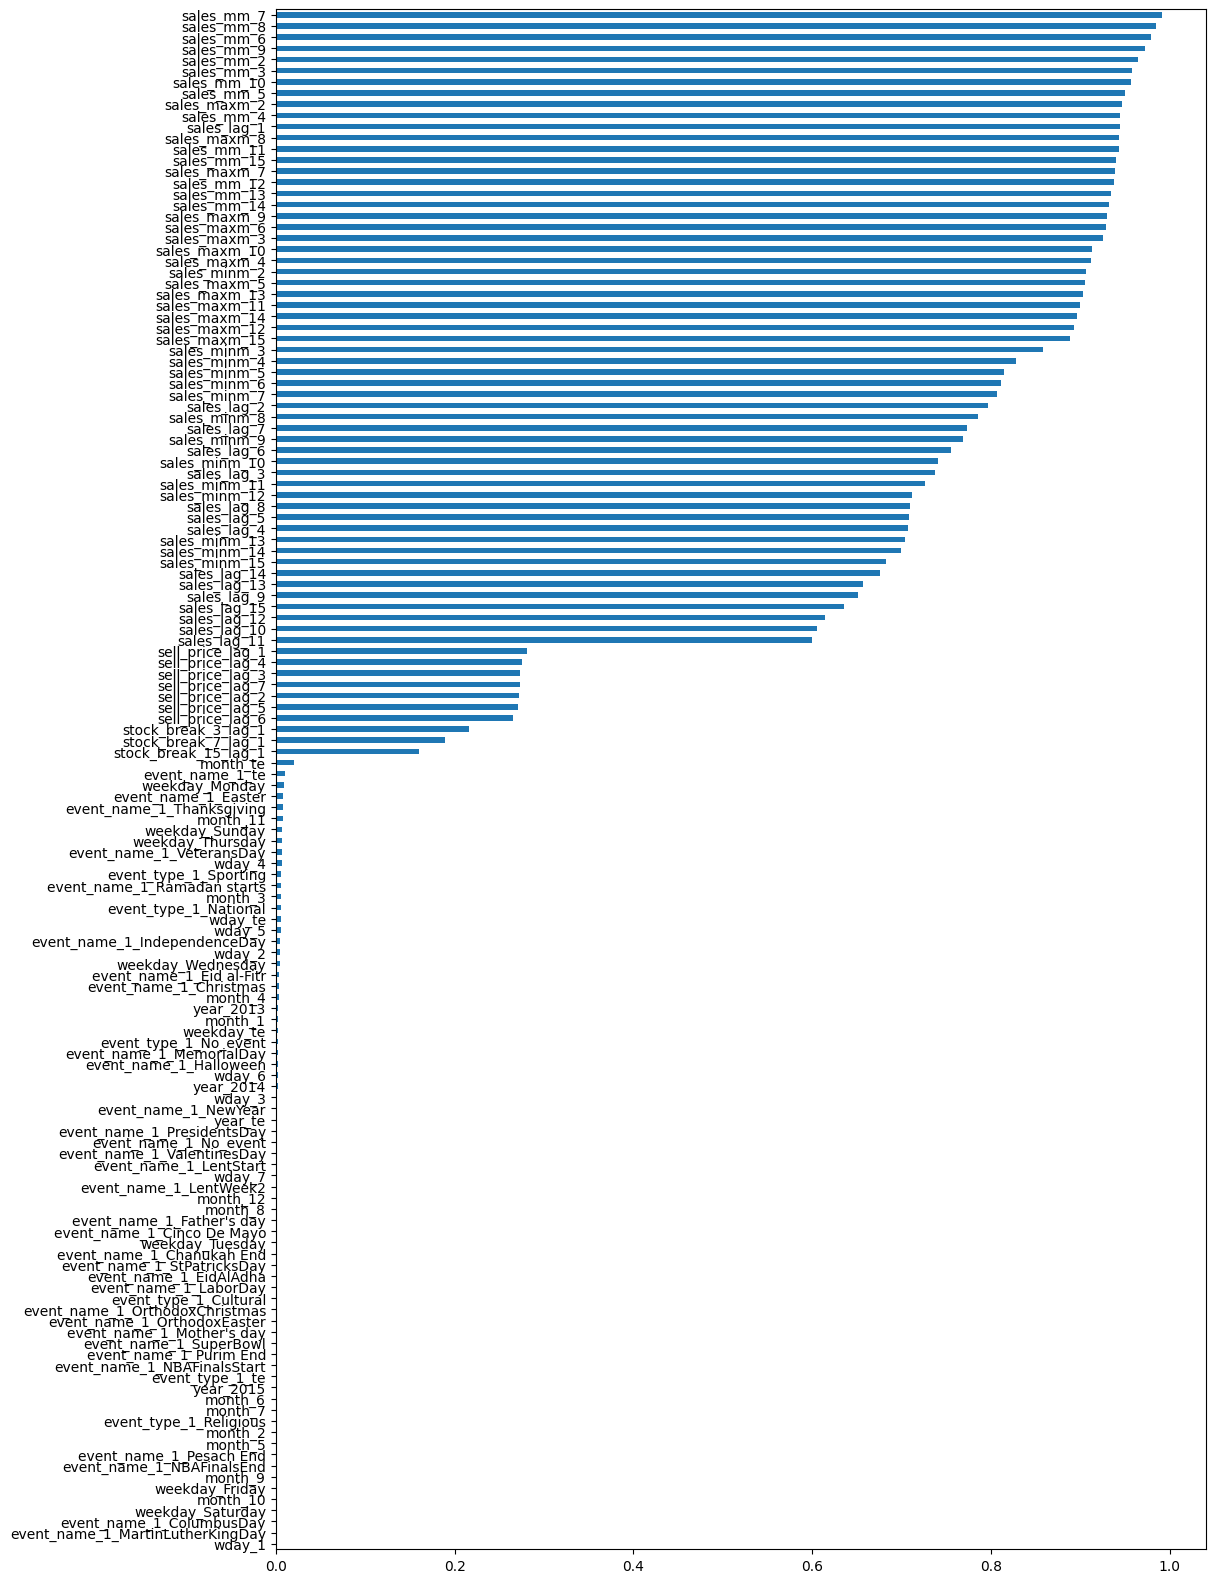

In [7]:
mutual_selector = mutual_info_regression(x,y)

rank_mi = ranking_mi(mutual_selector, mode = 'graphic')

#### Select the variables that pass the cut

##### Define the position of the last variable that will enter

We check the position of month_11.

In [8]:
ranking_mi(mutual_selector).reset_index().iloc[60:100]

,index,variable,importance_mi,ranking_mi
60,77,sell_price_lag_7,0.273191,60
61,72,sell_price_lag_2,0.272097,61
62,75,sell_price_lag_5,0.270835,62
63,76,sell_price_lag_6,0.265733,63
64,78,stock_break_3_lag_1,0.216608,64
65,79,stock_break_7_lag_1,0.189780,65
66,80,stock_break_15_lag_1,0.160493,66
67,66,month_te,0.020727,67
68,69,event_name_1_te,0.009802,68
69,23,weekday_Monday,0.009380,69


In [11]:
variable_limit_position = 72

##### Extract the names of the variables that enter

In [12]:
enter_mi = ranking_mi(mutual_selector).iloc[0:variable_limit_position].variable

##### Create the dataframe with the selection

In [13]:
x_mi = x[enter_mi].copy()

### Recursive Feature Elimination

#### Instantiate

In [14]:
rfe = RFE(estimator = XGBRegressor(use_label_encoder=False, n_jobs = -1, eval_metric='mae'))

#### Train

In [15]:
rfe.fit(x,y)

/Users/ricardoheredia/Desktop/retail-forecasting/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [08:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ricardoheredia/Desktop/retail-forecasting/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [08:13:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ricardoheredia/Desktop/retail-forecasting/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [08:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ricardoheredia/Desktop/retail-forecasting/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [08:13:30] WARNING: /Users/runner/work/xgb

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, device=None,
                           early_stopping_rounds=None, enable_categorical=False,
                           eval_metric='mae', feature_types=None, gamma=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, multi_strategy=None,
                           n_estimators=None, n_jobs=-1, num_parallel_tree=None,
                           random_state=None, ...))

##### Extract the names of the variables that enter

In [17]:
enter_rfe = x.columns[rfe.support_]

#### Create the dataframe with the selection

In [18]:
x_rfe = x[enter_rfe].copy()

In [19]:
x_rfe

,year_2013,month_3,month_11,month_12,wday_1,wday_2,event_name_1_Christmas,event_name_1_Thanksgiving,event_name_1_VeteransDay,wday_te,...,sales_maxm_4,sales_maxm_5,sales_maxm_6,sales_maxm_7,sales_maxm_8,sales_maxm_9,sales_maxm_10,sales_maxm_11,sales_maxm_13,sales_maxm_15
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.894333,...,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.096333,...,281.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.475667,...,206.0,281.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,34.801333,...,224.0,224.0,281.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,34.385333,...,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20975,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,26.096333,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,17.0,17.0,17.0
20976,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.475667,...,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0
20977,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,34.801333,...,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0
20978,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,34.385333,...,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0


### Permutation Importance

#### Create a function to show the result

In [20]:
def ranking_per(predictors, permutation):
    ranking_per = pd.DataFrame({'variable': predictors.columns, 'importance_per': permutation.importances_mean}).sort_values(by = 'importance_per', ascending = False)
    ranking_per['ranking_per'] = np.arange(0,ranking_per.shape[0])
    return(ranking_per)

#### Instantiate and train

In [23]:
import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')

xgb = XGBRegressor(use_label_encoder=False, n_jobs = -1, eval_metric='mae')

xgb.fit(x,y)

permutation = permutation_importance(xgb, 
                                     x, y, 
                                     scoring = 'neg_mean_absolute_percentage_error',
                                     n_repeats=3, n_jobs = -1)

/Users/ricardoheredia/Desktop/retail-forecasting/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [07:45:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#### Check output

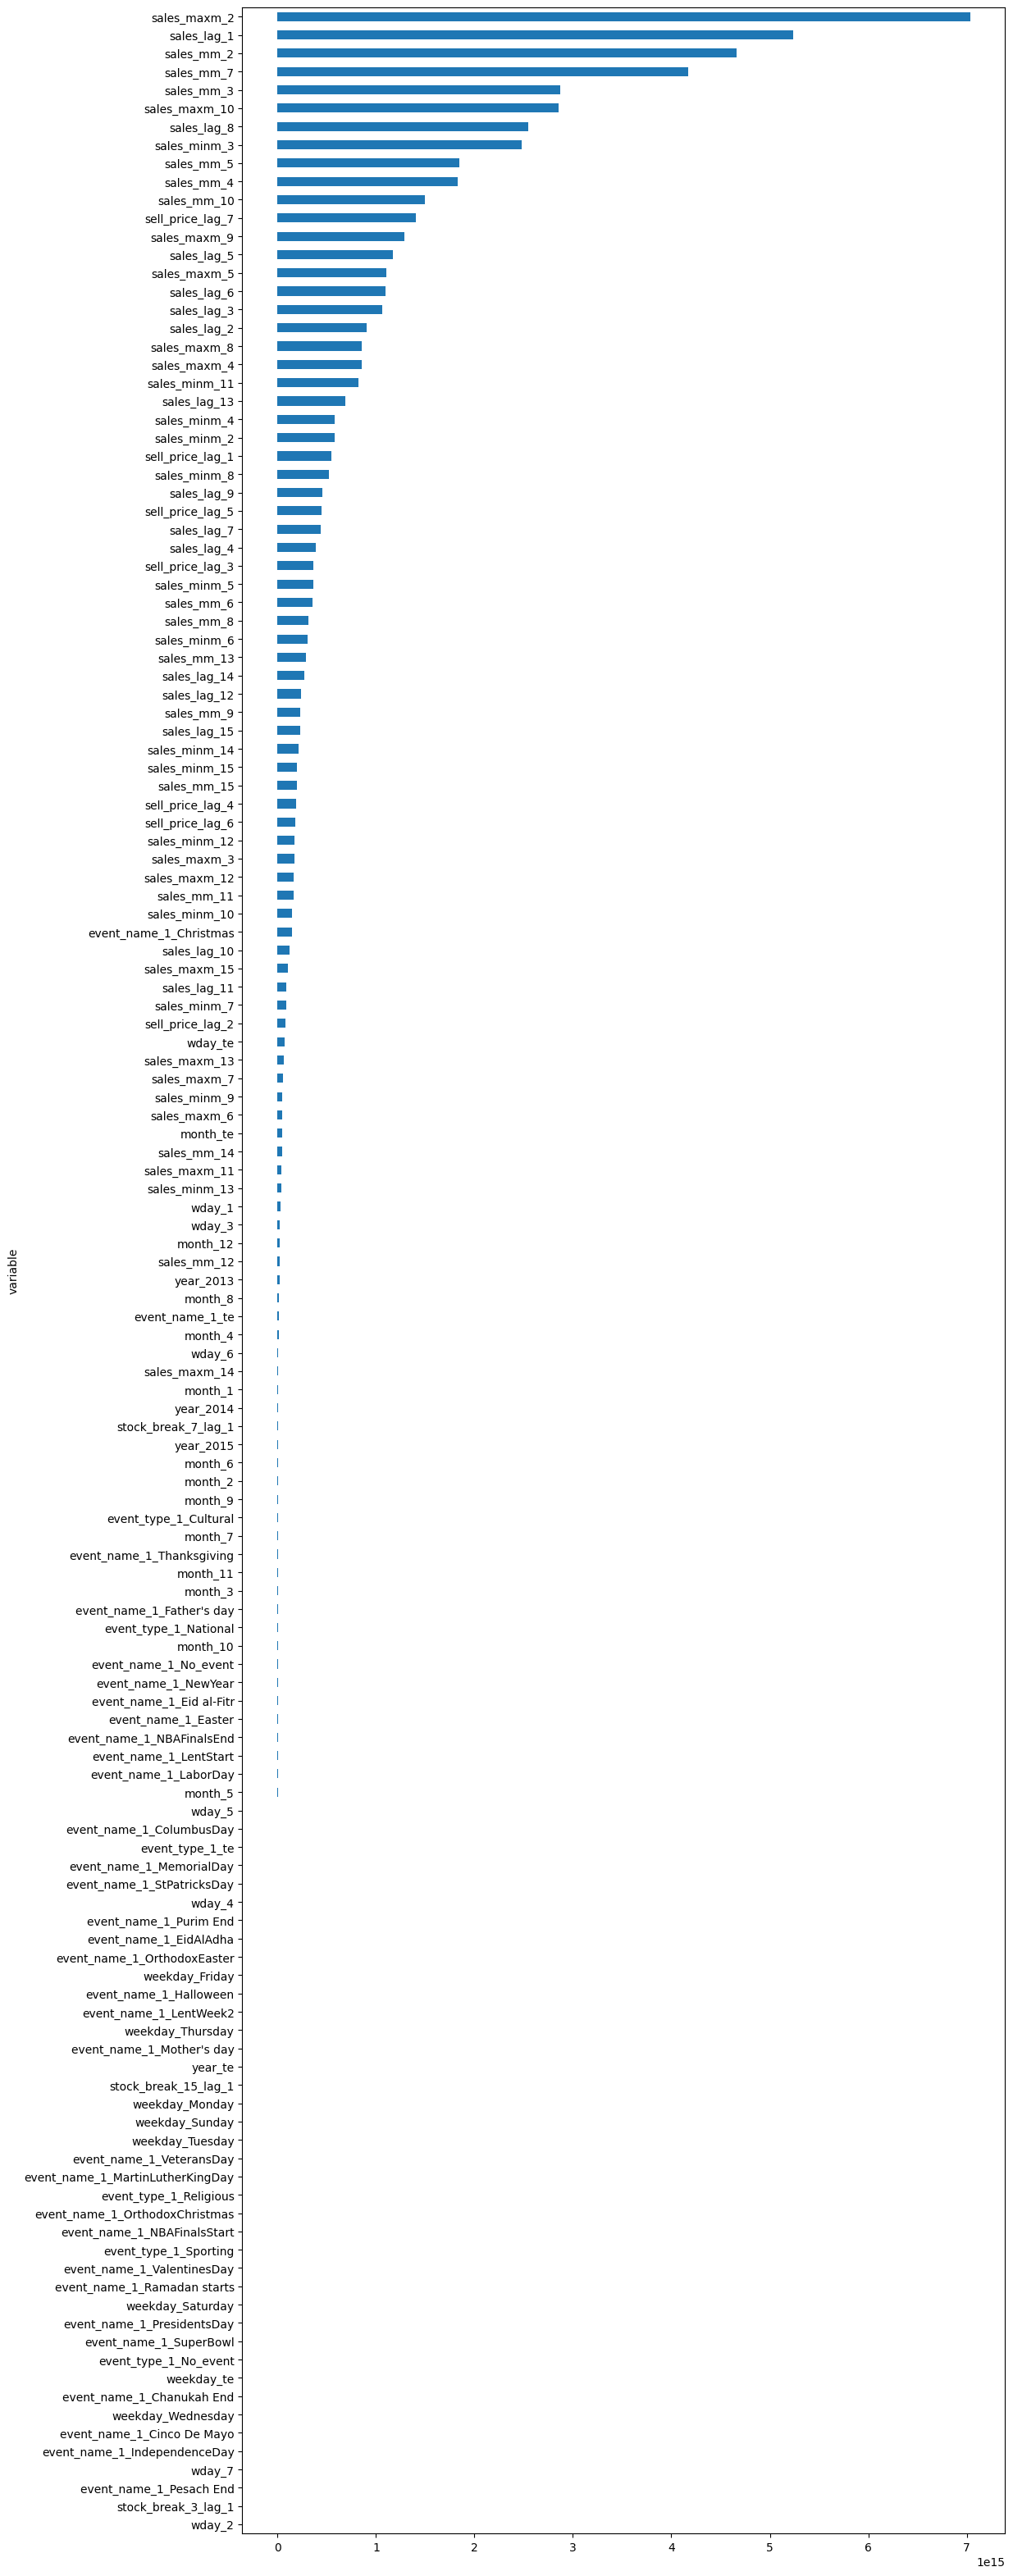

In [24]:
rank_per = ranking_per(x,permutation)

rank_per.set_index('variable').importance_per.sort_values().plot.barh(figsize = (12,40));

#### Select the variables that pass the cut

##### Define the position of the last variable that will enter

Revisar la posición de wday3.

In [25]:
rank_per.reset_index().iloc[50:100]

,index,variable,importance_per,ranking_per
50,30,event_name_1_Christmas,1.427423e+14,50
51,90,sales_lag_10,1.250818e+14,51
52,137,sales_maxm_15,1.023078e+14,52
53,91,sales_lag_11,8.915189e+13,53
54,101,sales_minm_7,8.846326e+13,54
55,72,sell_price_lag_2,8.328125e+13,55
56,67,wday_te,7.479457e+13,56
57,135,sales_maxm_13,6.716810e+13,57
58,129,sales_maxm_7,5.228237e+13,58
59,103,sales_minm_9,4.860060e+13,59


In [26]:
variable_limit_position = 66

##### Extract the names of the variables that enter

In [27]:
enter_per = rank_per.iloc[0:variable_limit_position].variable

##### Create the dataframe with the selection

In [28]:
x_per = x[enter_per].copy()

## SELECT THE FINAL METHOD

In [29]:
x_preselection = x_mi
#x_preseleccionado = x_rfe
#x_preseleccionado = x_per

## UNSUPERVISED METHODS

Won't do, because there are already many variables and we will model with tree-based algorithms.

## INCORPORATE SEGMENTATION VARIABLES

We will also need to add the segmentation variables.

In [30]:
x_preselection = pd.concat([df[['date','store_id','item_id']], x_preselection], axis=1)

## SAVE DATASETS AFTER VARIABLE PRESELECTION

In [31]:
path_x_preselection = TRANSFORMED_DATA_DIR / 'x_preselection.parquet'
path_y_preselection = TRANSFORMED_DATA_DIR / 'y_preselection.parquet'

In [33]:
x_preselection.to_parquet(path_x_preselection)

In [34]:
y_preselection = y.copy()
y_preselection

0        191
1        170
2        224
3        362
4        255
        ... 
20975     22
20976     10
20977     17
20978      7
20979      9
Name: sales, Length: 20980, dtype: int64

In [35]:
# Create a DataFrame from the Series
y_preselection_df = y_preselection.reset_index()  # Reset index to convert Series to DataFrame
y_preselection_df.columns = ['index', 'sales']  # Rename columns for clarity

In [36]:
# Save the DataFrame to Parquet format
y_preselection_df.to_parquet(path_y_preselection, index=False)  # Save without the index